# Module PHO-2-FOT2B-19

Author: Ahnjili

Contact: artificialnouveau@gmail.com



## How to use this notebook

There are only three things you need to do:

- Choose which cells to run
- Run the cells
- Change the filenames


### How to run cells

The document you are reading is not a static web page, but an interactive environment called a **Colab notebook** that lets you write and execute code.

For example, here is a **code cell** with a short Python script that computes a value, stores it in a variable, and prints the result:

In [ ]:
print("Hello World")

Hello World


In [ ]:
seconds_in_a_day = 24 * 60 * 60
seconds_in_a_day

86400

If you add '#' in front of the code, the code becomes a comment or inactive. See below

In [ ]:
print("Hello World")
#print('See? Nothing prints')

Hello World


To execute the code in the above cell, select it with a click and then either press the play button to the left of the code, or use the keyboard shortcut "Command/Ctrl+Enter". To edit the code, just click the cell and start editing.

Variables that you define in one cell can later be used in other cells:


In [ ]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

604800

### How to install and import packages


*pip install* will download packages from Python Package Index, a repository of software for the Python programming language where anyone can upload packages.

Don't worry about this section too much as I have written all the code necessary for you to install and import the relevant packages for this notebook. 

In [ ]:
!pip install exif

*import* or *from ... import* pulls the package to this notebook

In [ ]:
import exif 
from IPython.display import clear_output

## How to import your images

There are two ways to import your images:
- Manually uploading your photos to this notebook. You'll have to do this everytime you start the notebook. 

- Connect your notebook to an online folder. The folder can be in your google drive or a dropbox folder. 

Remove the # and run the following cell to upload a single image

In [ ]:
#run this line to see list of images that you've uploaded
!ls

Remove the # and run the following cell if you want to connect to your google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Let's analyze those images



#### Import the necessary libraries
*** You must run this cell but don't change anything

In [ ]:
from IPython.display import clear_output
from google.colab import files
import os
import os.path
import shutil
#import exifread
import urllib
import pandas as pd

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time


#### Custom functions
*** You must run this cell but don't change anything

In [ ]:
# def create_folder_of_images(images_path, file_ends_with = ".jpg"):
#   folder_of_images = []
#   for root, dirs, files in os.walk(images_path):
#     for f in files:
#       # I'm only interested in pictures
#       if f.endswith(file_ends_with):
#         folder_of_images.append(os.path.join(root, f))
#   return folder_of_images

def create_folder_of_images(images_path):
  folder_of_images = []
  for root, dirs, files in os.walk(images_path):
    for f in files:
      folder_of_images.append(os.path.join(root, f))
  return folder_of_images

def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256, display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)
  object_df = pd.DataFrame(
    {'object': result["detection_class_entities"],
     'score': result["detection_scores"]})
  object_df['object'] = object_df['object'].apply(lambda x:str(x).split("'")[1::2][0])
  object_df['image'] = path
  return object_df

def detect_img(image_url):
  start_time = time.time()
  image_path = download_and_resize_image(image_url, 640, 480)
  detector = hub.load(module_handle).signatures['default']
  object_df = run_detector(detector, image_path)
  end_time = time.time()
  print("Inference time:",end_time-start_time)
  return object_df

## How to extract the metadata from images

Exchangeable image file format (officially Exif,s) is a standard that specifies formats for images, sound, and ancillary tags used by digital cameras (including smartphones), scanners and other systems handling image and sound files recorded by digital cameras. 

The specification uses the following existing encoding formats with the addition of specific metadata tags: JPEG, TIFF Rev. 6.0 (RGB or YCbCr) for uncompressed image files, and RIFF WAV for audio files.It does not support JPEG 2000 or GIF encoded images. 

##### **** Run this cell. This cell contains all of the required libraries and functions

In [ ]:
! pip install exif
! pip3 install geopy
clear_output()

#from exif import Image
from exif import Image as exifImage
import PIL
import os
from geopy.geocoders import Nominatim
import time
from pprint import pprint
# instantiate a new Nominatim client
app = Nominatim(user_agent="tutorial")

def get_address_by_location(latitude, longitude, language="en"):
    """This function returns an address as raw from a location
    will repeat until success"""
    # build coordinates string to pass to reverse() function
    coordinates = f"{latitude}, {longitude}"
    # sleep for a second to respect Usage Policy
    time.sleep(1)
    try:
        return app.reverse(coordinates, language=language).raw['address']
    except:
        return get_address_by_location(latitude, longitude)

def exif_data(my_image):
  my_image = exifImage(my_image)
  if my_image.has_exif:
    try:
      print('This image was taken with: ')
      print(my_image.model, my_image.software)
    except:
      print('Model and software unknown')
    try:
      print('This image was taken on: ')
      print(my_image.datetime)
    except:
      print('Datetime unknown')
    try:
      print('Lat and Lon Coordinates:')
      print(my_image.gps_latitude, my_image.gps_longitude)
      # get the address info
      address = get_address_by_location(my_image.gps_latitude, my_image.gps_longitude)
      # print all returned data
      pprint(address)
    except:
      print('Location unknown')
    return my_image.model, my_image.software, my_image.datetime, [str(my_image.gps_latitude)], [str(my_image.gps_latitude)]
  else:
    print('Does not have EXIF')
    return 'Model Unknown', 'Software Unknown', 'Datetime Unknown', 'GPS Latitude Unknown', 'GPS Longitude Unknown'


#####Run these cells if you want to manually upload one 

In [ ]:
#insert your file name in between the ''

my_image = exifImage('IMG_4841_actual.jpg')
if my_image.has_exif:
  print(my_image.list_all())
else:
  print('This file does not have EXIF')

In [ ]:
#insert your file name in between the ''

model, software, datetime, gps_latitude, gps_longitude = exif_data('IMG_4841_actual.jpg')
exif_df =pd.DataFrame()
exif_df['image_path'] = ['IMG_4841_actual.jpg']
exif_df["model"] = [str(model)]
exif_df["software"] = [str(software)]
exif_df["datetime"] = [str(datetime)]
exif_df['gps_latitude'] = gps_latitude
exif_df['gps_longitude'] = gps_longitude
exif_df.head()


This image was taken with: 
iPhone 7 Plus 15.6.1
This image was taken on: 
2022:11:18 11:03:29
Lat and Lon Coordinates:
(52.0, 4.0, 21.75) (4.0, 19.0, 8.86)
{'country': 'Netherlands', 'country_code': 'nl'}


,image_path,model,software,datetime,gps_latitude,gps_longitude
0,IMG_4841_actual.jpg,iPhone 7 Plus,15.6.1,2022:11:18 11:03:29,"(52.0, 4.0, 21.75)","(52.0, 4.0, 21.75)"


In [ ]:
exif_df.to_csv('exif_df.csv')

# Remove # if you want to download this file
#files.download('exif_df.csv')

#####Run this cell if you want to analyze images in your google drive folder

In [ ]:
! ls /content/drive/MyDrive/Projects

In [ ]:
#insert your filepath in between the '', change the file_ends_with to suit your photo format

folder_of_images = create_folder_of_images('/content/drive/MyDrive/Projects/R2203HKUWorkshop/Photos/')

exif_df = []
for img in folder_of_images:
  print(img)
  my_image = exifImage(img)
  exif_temp =pd.DataFrame()
  if my_image.has_exif:
    print('hey')
    model, software, datetime, gps_latitude, gps_longitude = exif_data(img)
    exif_temp['img'] = [str(img)]
    exif_temp["model"] = [str(model)]
    exif_temp["software"] = [str(software)]
    exif_temp["datetime"] = [str(datetime)]
    exif_temp['gps_latitude'] = gps_latitude
    exif_temp['gps_longitude'] = gps_longitude
    exif_df.append(exif_temp)
  else:
    print('nope')
    print('This file does not have EXIF')
    exif_temp['img'] = [str(img)]
    exif_temp["model"] = ['Model Unknown']
    exif_temp["software"] = ['Software Unknown']
    exif_temp["datetime"] = ['Datetime Unknown']
    exif_temp['gps_latitude'] = ['GPS Latitude Unknown']
    exif_temp['gps_longitude'] = ['GPS Longitude Unknown']
    exif_df.append(exif_temp)
  print(' ')

exif_df = pd.concat(exif_df)
exif_df.head(100)

In [ ]:
exif_df.to_csv('exif_df.csv')

# Remove # if you want to download this file
#files.download('exif_df.csv')

#####Run this cell if you want to analyze images from several online links

In [ ]:
# insert your image urls below, always in between " " and with a comma afterwards
image_urls = [
  "https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg",
  "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg",
  "https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg",
  ]


exif_df = []
for img in image_urls:
  print(img)
  downloaded_image_path = download_and_resize_image(img, 1280, 856, False)
  my_image = exifImage(downloaded_image_path)
  exif_temp =pd.DataFrame()
  if my_image.has_exif:
    print('hey')
    model, software, datetime, gps_latitude, gps_longitude = exif_data(img)
    exif_temp['img'] = [str(img)]
    exif_temp["model"] = [str(model)]
    exif_temp["software"] = [str(software)]
    exif_temp["datetime"] = [str(datetime)]
    exif_temp['gps_latitude'] = gps_latitude
    exif_temp['gps_longitude'] = gps_longitude
    exif_df.append(exif_temp)
  else:
    print('nope')
    print('This file does not have EXIF')
    exif_temp['img'] = [str(img)]
    exif_temp["model"] = ['Model Unknown']
    exif_temp["software"] = ['Software Unknown']
    exif_temp["datetime"] = ['Datetime Unknown']
    exif_temp['gps_latitude'] = ['GPS Latitude Unknown']
    exif_temp['gps_longitude'] = ['GPS Longitude Unknown']
    exif_df.append(exif_temp)
  print(' ')

exif_df = pd.concat(exif_df)
exif_df.head(100)

In [ ]:
exif_df.to_csv('exif_df.csv')

# Remove # if you want to download this file
#files.download('exif_df.csv')

## Emotion and Biometric recognition

In our daily life, we knowingly or unknowingly carry out different types of Facial Expressions. These movements convey the emotional state of humans.

We can judge the mood and mental state of the next person by his Facial Expression. In the early Twentieth century, Ekman and Friesen defined `seven` basic emotions.

This expression does not change with cultures, they are universal. Six Facial Expressions are:-

    Anger
    Disgust
    Fear
    Happiness
    Neutral
    Sadness
    Surprise

Here we will use two Facial Expression Recgonition libraries, FER and deepFace.

Facial Expression Recognition Library is developed by Justin Shenk. This Library requires OpenCV>=3.2 and Tensorflow>=1.7.0 dependencies installed in the system. Faces are detected using OpenCV’s Haar Cascade classifier.

#### FER algorithm (emotion only)
###### **** Run this cell. This cell contains all of the required libraries and functions

In [ ]:
! pip install FER
! pip install deepface

clear_output()

from fer import FER
from deepface import DeepFace

import matplotlib.pyplot as plt 
%matplotlib inline


def custom_FER(img_path):
  test_image_one = plt.imread(img_path)
  emo_detector = FER(mtcnn=True)
  # Capture all the emotions on the image
  captured_emotions = emo_detector.detect_emotions(test_image_one)
  #plt.imshow(test_image_one)
  # Use the top Emotion() function to call for the dominant emotion in the image
  dominant_emotion, emotion_score = emo_detector.top_emotion(test_image_one)
  clear_output()
  # Print all captured emotions with the image
  return captured_emotions[0]['emotions'], dominant_emotion, emotion_score

def print_FER_results(captured_emotions, dominant_emotion, emotion_score):
  print("These are all the captured emotions: ")
  print(captured_emotions)
  print("The most dominant emotion is " + dominant_emotion + ". The emotion score was "+str(emotion_score))

def custom_deepface(img_path):
  obj = DeepFace.analyze(img_path = img_path, actions = ['age', 'gender', 'race', 'emotion'])
  deepface_df = pd.DataFrame(obj.items()).set_index(0).transpose()
  deepface_df.drop(['region'],axis=1,inplace=True)
  deepface_df = deepface_df.join(deepface_df['race'].apply(pd.Series))
  deepface_df = deepface_df.join(deepface_df['emotion'].apply(pd.Series))
  deepface_df = round(deepface_df,2)
  deepface_df = deepface_df.drop(['emotion','race'],axis=1)
  return deepface_df

#####Run these cells if you want to analyze one photo that you want to manually upload

In [ ]:
#insert your filename in between the ''

captured_emotions, dominant_emotion, emotion_score = custom_FER('IMG_4841_actual.jpg')
print_FER_results(captured_emotions, dominant_emotion, emotion_score)
face_df = pd.DataFrame(captured_emotions.items()).set_index(0).transpose()
face_df['image_path'] = 'IMG_4841_actual.jpg'

face_df.head(100)

These are all the captured emotions: 
{'angry': 0.46, 'disgust': 0.0, 'fear': 0.04, 'happy': 0.21, 'sad': 0.05, 'surprise': 0.0, 'neutral': 0.23}
The most dominant emotion is angry. The emotion score was 0.46


,angry,disgust,fear,happy,sad,surprise,neutral,image_path
1,0.46,0.0,0.04,0.21,0.05,0.0,0.23,IMG_4841_actual.jpg


In [ ]:
face_df.to_csv('face_df.csv')

# Remove # if you want to download this file
#files.download('face_df.csv')

#####Run this cell if you want to analyze images in your google drive folder


In [ ]:
#insert your filepath in between the ''

folder_of_images = create_folder_of_images('/content/drive/MyDrive/Projects/R2203HKUWorkshop/Photos/')
face_df = []
for img in folder_of_images:
  print(img)
  try:
    captured_emotions, dominant_emotion, emotion_score = custom_FER(img)
    print_FER_results(captured_emotions, dominant_emotion, emotion_score)
    print(' ')
    face_temp = pd.DataFrame(captured_emotions.items()).set_index(0).transpose()
    face_temp['image_path'] = img
  except:
    data = {'anger':['unknown'],
          'disgust':['unknown'],
          'fear':['unknown'],
          'happy':['unknown'],
          'sad':['unknown'],
          'surprise':['unknown'],
          'neutral':['unknown'],
          'image_path':[str(img)]}
    face_temp = pd.DataFrame(data)
  face_df.append(face_temp)
face_df = pd.concat(face_df)
face_df.head(100)

In [ ]:
  face_df.to_csv('face_df.csv')

# Remove # if you want to download this file
#files.download('face_df.csv')

#####Run these cells if you want to analyze images from the web 

In [ ]:
#insert your image urls here, always between " " and with a comma at the end

image_urls = [
  'https://upload.wikimedia.org/wikipedia/commons/thumb/5/5f/Mark_Rutte_2015_%281%29_%28cropped%29.jpg/440px-Mark_Rutte_2015_%281%29_%28cropped%29.jpg'
  "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Rutger_Hauer_%282018%29.jpg/440px-Rutger_Hauer_%282018%29.jpg",
  "https://upload.wikimedia.org/wikipedia/commons/thumb/1/17/Beyonc%C3%A9_at_The_Lion_King_European_Premiere_2019.png/440px-Beyonc%C3%A9_at_The_Lion_King_European_Premiere_2019.png"
  ]

face_df = []
for img in image_urls:
  try:
    downloaded_image_path = download_and_resize_image(img, new_width=256, new_height=256, display=False)
    print(img)
    captured_emotions, dominant_emotion, emotion_score = custom_FER(downloaded_image_path)
    print_FER_results(captured_emotions, dominant_emotion, emotion_score)
    print(' ')
    face_temp = pd.DataFrame(captured_emotions.items()).set_index(0).transpose()
    face_temp['image_path'] = img
    face_df.append(face_temp)
  except:
    print('Sorry, this image could not downloaded at this time')
    data = {'anger':['unknown'],
          'disgust':['unknown'],
          'fear':['unknown'],
          'happy':['unknown'],
          'sad':['unknown'],
          'surprise':['unknown'],
          'neutral':['unknown'],
          'image_path':[str(img)]}
    face_temp = pd.DataFrame(data)
    face_df.append(face_temp)
# see pd.concat documentation for more info
face_df = pd.concat(face_df)
face_df.head(100)

In [ ]:
face_df.to_csv('face_df.csv')

# Remove # if you want to download this file
#files.download('face_df.csv')

The *deepface* library allows for the recognition of age, gender, race, and emotion. To read more about the *deepface* library go to: https://pypi.org/project/nvface/

#### DeepFace algorithm (emotion, race, gender, age)
#####Run these cells if you want to analyze one photo that you want to manually upload

In [ ]:
#insert your filename here 

deepface_df = custom_deepface('IMG_4841_actual.jpg')
clear_output()
deepface_df.head()

,age,gender,dominant_race,dominant_emotion,asian,indian,black,white,middle eastern,latino hispanic,angry,disgust,fear,happy,sad,surprise,neutral
1,27,Man,asian,neutral,84.22,4.81,1.19,1.25,0.23,8.31,0.02,0.0,0.01,0.01,0.24,0.0,99.72


In [ ]:
deepface_df.to_csv('face_df.csv')

# Remove # if you want to download this file
#files.download('deepface_df.csv')

#####Run this cell if you want to analyze images in your google drive folder

In [ ]:
#insert your file path here

folder_of_images = create_folder_of_images('/content/drive/MyDrive/Projects/R2203HKUWorkshop/Photos/', file_ends_with = ".jpg")
deepface_df = []
for img in folder_of_images:
  print(img)
  deepface_temp = custom_deepface(img)
  deepface_temp['img'] = img
  deepface_df.append(deepface_temp)
deepface_df = pd.concat(deepface_df)
clear_output()
deepface_df.head(100)


In [ ]:
deepface_df.to_csv('face_df.csv')

# Remove # if you want to download this file
#files.download('deepface_df.csv')

#####Run these cells if you want to analyze one or more images from the web

In [ ]:
#insert your image urls here, always between " " with a comma at the end

image_urls = [
    "https://upload.wikimedia.org/wikipedia/commons/thumb/5/5f/Mark_Rutte_2015_%281%29_%28cropped%29.jpg/440px-Mark_Rutte_2015_%281%29_%28cropped%29.jpg"
  ]

deepface_df = []
for img in image_urls:
  try:
    downloaded_image_path = download_and_resize_image(img, new_width=256, new_height=256, display=False)
    deepface_temp = custom_deepface(downloaded_image_path)
    deepface_temp['img'] = img
    deepface_df.append(deepface_temp)
  except:
    print('Sorry, this image could not downloaded at this time')
    data = {'anger':['unknown'],
          'disgust':['unknown'],
          'fear':['unknown'],
          'happy':['unknown'],
          'sad':['unknown'],
          'surprise':['unknown'],
          'neutral':['unknown'],
          'image_path':[str(img)]}
    deepface_temp = pd.DataFrame(data)
    deepface_df.append(deepface_temp)
deepface_df = pd.concat(deepface_df)
clear_output()
deepface_df.head()

In [ ]:
deepface_df.to_csv('deepface_df.csv')

# Remove # if you want to download this file
#files.download('deepface_df.csv')

## Object Recognition

This section demonstrates use of a TF-Hub module trained to perform object detection.

To run this section, you will need to use GPU. To do that, go to Runtime > Change runtime type > Hardware accelator > GPU

##### **** Run this cell. This cell contains all of the required libraries and functions

In [ ]:
# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())




2.9.2
The following GPU devices are available: /device:GPU:0


Pick an object detection module and apply on the downloaded image. Modules: FasterRCNN+InceptionResNet V2: high accuracy, ssd+mobilenet V2: small and fast.


In [ ]:
#this cell will run for a few minutes
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]


#####Run these cells if you want to analyze one photo that you want to manually upload

Found 100 objects.
Inference time:  46.4955792427063


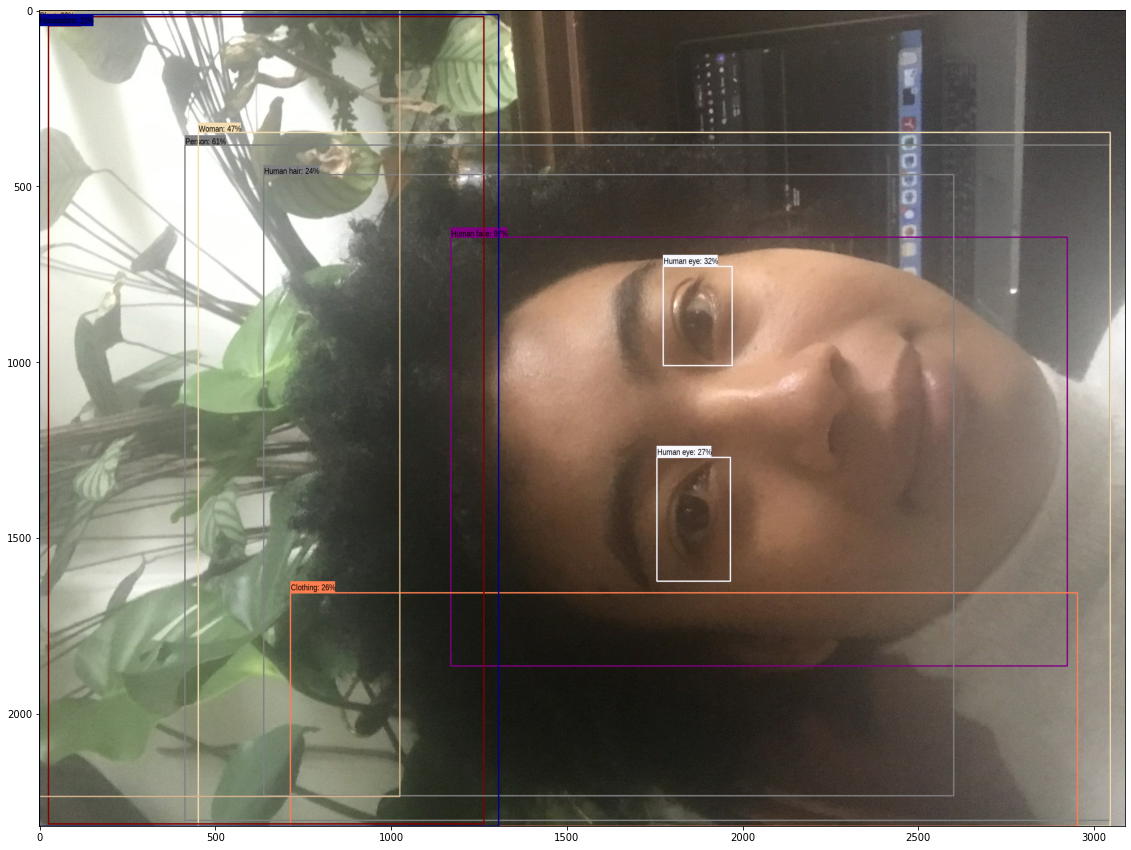

In [ ]:
#insert your filename here

detector = hub.load(module_handle).signatures['default']
object_df = run_detector(detector, 'IMG_4841_actual.jpg')


In [ ]:
object_df.head(100)


In [ ]:
object_df.to_csv('object_df.csv')

# Remove # if you want to download this file
#files.download('object_df.csv')

#####Run these cells if you want to analyze a folder of images 


In [ ]:
#insert your filepath here

folder_of_images = create_folder_of_images('/content/drive/MyDrive/Projects/R2203HKUWorkshop/Photos/')
object_df = []
for img in folder_of_images:
  print(img)
  object_temp = run_detector(detector, img)
  object_df.append(object_temp)
object_df = pd.concat(object_df)
object_df.head()

In [ ]:
object_df.head(100)

In [ ]:
object_df.to_csv('object_df.csv')

# Remove # if you want to download this file
#files.download('object_df.csv')

#####Run these cells if you want to analyze one or more images from the web

In [ ]:
#insert your image urls here, always between " " with a comma at the end

image_urls = [
  "https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg",
  "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg",
  "https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg",
  ]

object_df = []
for img in image_urls:
  print(img)
  object_temp = detect_img(img)
  object_df.append(object_temp)
object_df = pd.concat(object_df)
# detect_img(image_urls[0])
# detect_img(image_urls[1])
# detect_img(image_urls[2])

In [ ]:
object_df.head()

In [ ]:
object_df.to_csv('object_df.csv')

# Remove # if you want to download this file
#files.download('object_df.csv')